# Setup

In [41]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchmetrics import Accuracy

In [42]:
if os.path.exists("./data"):
    print("Data already exists, skipping download...")
else:
    if os.path.exists("./data.zip"): 
        # you can place the unmodified zip file of the data after renaming it as data.zip to avoid downloading 
        print("Data exists but not extracted, extracting...")
    else:
        # if the data is not found, it is going to download it (caution: it is a 2.7GB zip file!)
        print("Data not found, downloading...")
        !curl -L -o ./data.zip https://www.kaggle.com/api/v1/datasets/download/vipoooool/new-plant-diseases-dataset
    
    !unzip data.zip -d data
    !rm -rf "./data/New Plant Diseases Dataset(Augmented)"

    # organising the data in the format required for torchvision.datasets.ImageFolder
    !mv "./data/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)" "./data/dataset"
    !mv ./data/test/test ./data/manual_test
    !rm -rf ./data/test
    !rm -rf "./data/new plant diseases dataset(augmented)"
    !mv ./data/dataset/valid ./data/dataset/test

Data already exists, skipping download...


In [43]:
train_path = "./data/dataset/train"
test_path = "./data/dataset/test"

In [44]:
train_image_list = list(Path(train_path).glob("*/*.jpg", case_sensitive=False))
test_image_list = list(Path(test_path).glob("*/*.jpg", case_sensitive=False))

In [45]:
len(train_image_list), len(test_image_list)

(70295, 17572)

# Data Exploration

In [46]:
categories = { image_path.parent.name for image_path in train_image_list }
categories = sorted(list(categories))
len(categories)

38

In [47]:
from helpers import get_is_healthy_plant_disease

In [48]:
results = [ get_is_healthy_plant_disease(category) for category in categories ]
results

[{'is_healthy': False, 'plant': 'apple', 'disease': 'apple scab'},
 {'is_healthy': False, 'plant': 'apple', 'disease': 'black rot'},
 {'is_healthy': False, 'plant': 'apple', 'disease': 'cedar apple rust'},
 {'is_healthy': True, 'plant': 'apple', 'disease': None},
 {'is_healthy': True, 'plant': 'blueberry', 'disease': None},
 {'is_healthy': False, 'plant': 'cherry', 'disease': 'powdery mildew'},
 {'is_healthy': True, 'plant': 'cherry', 'disease': None},
 {'is_healthy': False, 'plant': 'corn', 'disease': 'cercospora leaf spot'},
 {'is_healthy': False, 'plant': 'corn', 'disease': 'common rust'},
 {'is_healthy': False, 'plant': 'corn', 'disease': 'northern leaf blight'},
 {'is_healthy': True, 'plant': 'corn', 'disease': None},
 {'is_healthy': False, 'plant': 'grape', 'disease': 'black rot'},
 {'is_healthy': False, 'plant': 'grape', 'disease': 'esca (black measles)'},
 {'is_healthy': False,
  'plant': 'grape',
  'disease': 'leaf blight (isariopsis leaf spot)'},
 {'is_healthy': True, 'plant'

In [49]:
from helpers import get_all_images_by_category

In [50]:
categorywise_data_count = []

for result in results:
    plant = result["plant"]

    if result["disease"] is None:
        disease = "healthy"
    else:
        disease = result["disease"]

    selected_images = get_all_images_by_category(plant, disease, train_image_list)
    categorywise_data_count.append([plant, disease, len(selected_images)])

categorywise_data_count = pd.DataFrame(categorywise_data_count, columns=["plant", "disease", "count"])
categorywise_data_count

,plant,disease,count
0,apple,apple scab,2016
1,apple,black rot,1987
2,apple,cedar apple rust,1760
3,apple,healthy,2008
4,blueberry,healthy,1816
5,cherry,powdery mildew,1683
6,cherry,healthy,1826
7,corn,cercospora leaf spot,1642
8,corn,common rust,1907
9,corn,northern leaf blight,1908


In [51]:
categorywise_data_count["count"].sum(), len(train_image_list)

(np.int64(70295), 70295)

In [52]:
plt.imread(train_image_list[0]).shape

(256, 256, 3)

In [53]:
from transforms import train_data_transform

train_data = datasets.ImageFolder(train_path, train_data_transform)
train_data

Dataset ImageFolder
    Number of datapoints: 70295
    Root location: ./data/dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.8, 1.2), hue=(-0.1, 0.1))
               ToTensor()
           )

In [54]:
from transforms import eval_data_transform

test_data = datasets.ImageFolder(test_path, eval_data_transform)
test_data

Dataset ImageFolder
    Number of datapoints: 17572
    Root location: ./data/dataset/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [55]:
lengths = [len(test_data) // 3, len(test_data) - len(test_data) // 3]

validate_data, test_data = random_split(test_data, lengths)

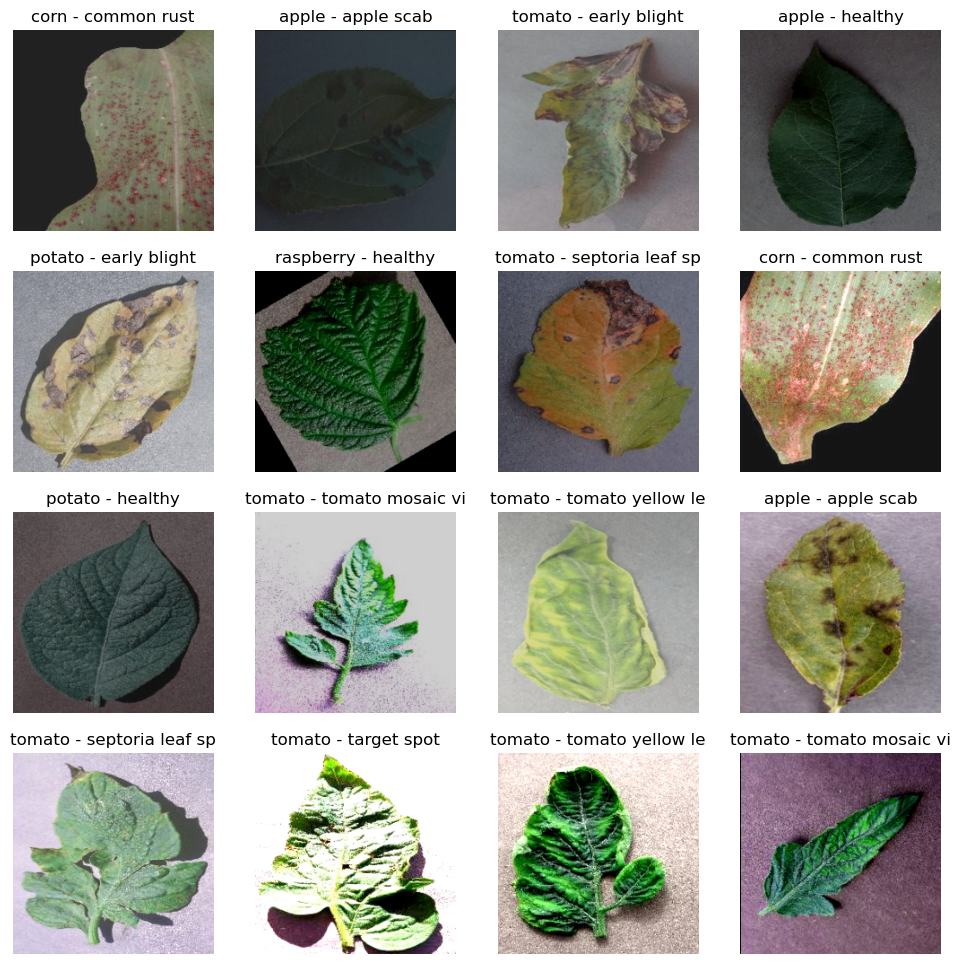

In [56]:
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

np.random.seed(42)
random_indices = np.random.randint(0, len(train_data), (16,))

for row in range(4):
    for col in range(4):
        index = random_indices[row*4 + col]
        image, label = train_data[index]
        result = get_is_healthy_plant_disease(train_data.classes[label])
        title_text = result["plant"]
        if result["is_healthy"]:
            title_text += " - healthy"
        else:
            title_text += " - " + result["disease"]

        axes[row][col].imshow(image.permute(1, 2, 0))
        axes[row][col].set_title(title_text[0:min(25, len(title_text))])
        axes[row][col].axis(False)

# Model Development

In [57]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS)

validate_dataloader = DataLoader(validate_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS)

In [58]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [59]:
from models import MobileNetV2Model

torch.manual_seed(42)

mobilenet_v2_model = MobileNetV2Model(
    output_shape=len(train_data.classes
                     )).to(device)
mobilenet_v2_model

MobileNetV2Model(
  (model): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size

In [60]:
from torchinfo import summary

summary(mobilenet_v2_model, input_size=[32, 3, 224, 224])

Layer (type:depth-idx)                                  Output Shape              Param #
MobileNetV2Model                                        [32, 38]                  --
├─MobileNetV2: 1-1                                      [32, 38]                  --
│    └─Sequential: 2-1                                  [32, 1280, 7, 7]          --
│    │    └─Conv2dNormActivation: 3-1                   [32, 32, 112, 112]        (928)
│    │    └─InvertedResidual: 3-2                       [32, 16, 112, 112]        (896)
│    │    └─InvertedResidual: 3-3                       [32, 24, 56, 56]          (5,136)
│    │    └─InvertedResidual: 3-4                       [32, 24, 56, 56]          (8,832)
│    │    └─InvertedResidual: 3-5                       [32, 32, 28, 28]          (10,000)
│    │    └─InvertedResidual: 3-6                       [32, 32, 28, 28]          (14,848)
│    │    └─InvertedResidual: 3-7                       [32, 32, 28, 28]          (14,848)
│    │    └─InvertedResidu

In [61]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mobilenet_v2_model.parameters(), 1)

In [62]:
def report_model(model: torch.nn.Module,
                 test_dataloader: torch.utils.data.DataLoader,
                 num_classes: int):
    acc_sum = 0

    device = next(iter(model.parameters())).device.type

    model.eval()
    
    for X_test, y_test in test_dataloader:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        with torch.inference_mode():
            y_pred = model(X_test)
            y_pred = y_pred.argmax(dim=1)
            accuracy_fn = Accuracy('multiclass', num_classes=num_classes).to(device)
            acc = accuracy_fn(y_pred, y_test)
            acc_sum += acc

    avg_acc = acc_sum / len(test_dataloader)        
    
    print(f"Accuracy: {round((avg_acc*100).item(), 2)}%")

In [63]:
def train_step(model: torch.nn.Module, 
               train_dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    device = next(iter(model.parameters())).device.type
    
    model.train()
    
    for X_train, y_train in train_dataloader:
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    model.eval()


In [64]:
def test_step(model: torch.nn.Module, 
              test_dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              num_classes: int):
    acc_sum = 0
    loss_sum = 0

    device = next(iter(model.parameters())).device.type
    
    model.eval()
    
    for X_test, y_test in test_dataloader:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        with torch.inference_mode():
            y_pred = model(X_test)
            loss = loss_fn(y_pred, y_test)
            loss_sum += loss
            y_pred = y_pred.argmax(dim=1)
            accuracy_fn = Accuracy('multiclass', num_classes=num_classes).to(device)
            acc = accuracy_fn(y_pred, y_test)
            acc_sum += acc

    avg_loss = loss_sum / len(test_dataloader)
    avg_acc = acc_sum / len(test_dataloader)
    
    print(f"Loss: {avg_loss}, Accuracy: {round((avg_acc*100).item(), 2)}%")

In [65]:
report_model(mobilenet_v2_model, test_dataloader, len(train_data.classes))

Accuracy: 2.85%


In [66]:
EPOCHS = 3

for epoch in range(EPOCHS):
    print(f"epoch {epoch+1}/{EPOCHS}")
    train_step(mobilenet_v2_model, train_dataloader, loss_fn, optimizer)
    test_step(mobilenet_v2_model, validate_dataloader, loss_fn, len(train_data.classes))

epoch 1/3
Loss: 0.17209747433662415, Accuracy: 94.46%
epoch 2/3
Loss: 0.2017061710357666, Accuracy: 94.07%
epoch 3/3
Loss: 0.13354797661304474, Accuracy: 95.86%


In [67]:
report_model(mobilenet_v2_model, test_dataloader, len(train_data.classes))

Accuracy: 95.79%


# Saving the Model

In [68]:
os.makedirs("./models", exist_ok=True)
torch.save(mobilenet_v2_model.state_dict(), "./models/mobilenet_v2_model.pt")

In [69]:
import pickle

os.makedirs("./models", exist_ok=True)
with open("./models/classes.pkl", "wb") as f:
    pickle.dump(train_data.classes, f)